# Analyzing GEJson segmentation data using cellseg_gsontools

https://okunator.github.io/cellseg_gsontools/getting_started/quick_start/

In [1]:
from cellseg_gsontools.utils import read_gdf
from cellseg_gsontools.plotting import plot_gdf
from cellseg_gsontools.geometry import shape_metric

In [2]:
cells = read_gdf("../data/B 18.11086 he  - 2022-07-27 11.13.19.geojson")

/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'st

In [4]:
cells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11455 entries, 0 to 11454
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   classification  11455 non-null  object  
 1   geometry        11455 non-null  geometry
 2   class_name      0 non-null      object  
dtypes: geometry(1), object(2)
memory usage: 268.6+ KB


In [5]:
cells.head(4)

,classification,geometry,class_name
0,Epithelial,"POLYGON ((16644.00000 19416.00000, 16652.00000...",None
1,Lymphocyte,"POLYGON ((16554.00000 19428.00000, 16558.00000...",None
2,Epithelial,"POLYGON ((16676.00000 19406.00000, 16682.00000...",None
3,Epithelial,"POLYGON ((16614.00000 19442.00000, 16618.00000...",None


<Axes: >

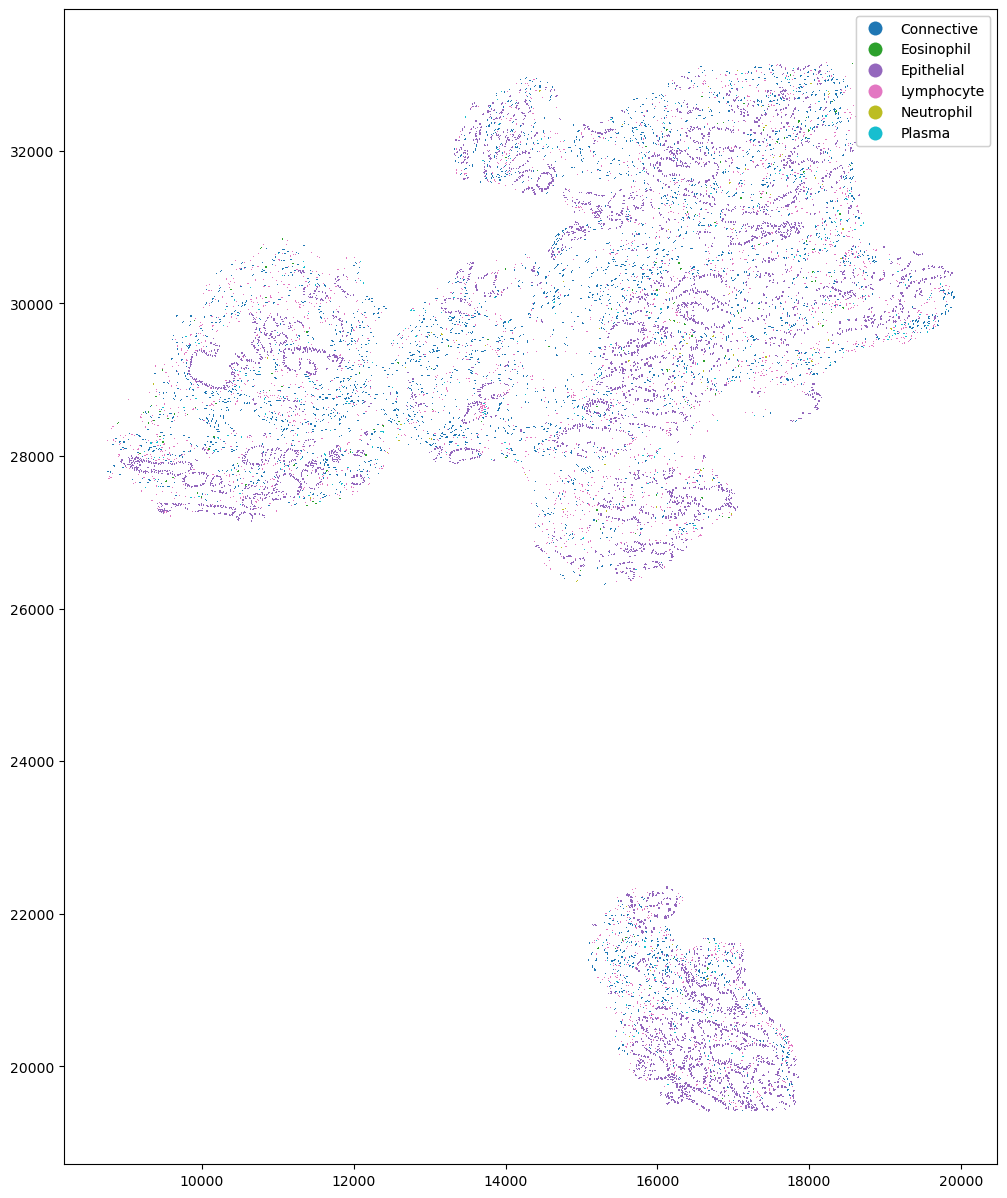

In [6]:
# cells.plot(column="classification", figsize=(15, 15))
plot_gdf(cells, col="classification", figsize=(15, 15))

In [13]:
some_cells = cells.head(1000)
some_cells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   classification  1000 non-null   object  
 1   geometry        1000 non-null   geometry
 2   class_name      0 non-null      object  
dtypes: geometry(1), object(2)
memory usage: 23.6+ KB


In [14]:

some_cells = shape_metric(
    some_cells,
    metrics=["area", "sphericity", "eccentricity"],
    parallel=False
)
some_cells.head(4)

/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/geometry/shape_metrics.py:605: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[f"{col_prefix}area"] = gdf.area


,classification,geometry,class_name,area,sphericity,eccentricity
0,Epithelial,"POLYGON ((16644.00000 19416.00000, 16652.00000...",None,444.0,0.619371,0.618590
1,Lymphocyte,"POLYGON ((16554.00000 19428.00000, 16558.00000...",None,196.0,0.678730,0.000000
2,Epithelial,"POLYGON ((16676.00000 19406.00000, 16682.00000...",None,928.0,0.626598,0.661438
3,Epithelial,"POLYGON ((16614.00000 19442.00000, 16618.00000...",None,536.0,0.547997,0.831479


# We can analyze the tumor regions (annotation from Yuri Tolkach) in the high attention areas of our network (pivotal to predict response/non response)

What if high attention areas lie outside the tumor?

See: https://kazumatsuda.medium.com/aggregating-information-of-two-overlaying-geodataframes-using-geopandas-with-code-example-dcee1df74e0e
